In [32]:
%load_ext autoreload
%autoreload 2
import torch
from dataset import show_images, make_grid, get_dataloader, save_images
from UNet import UNet
from scheduler import DDPMScheduler, DDIMScheduler
from pipeline import DiffusionPipeline
from train import train
import numpy as np
batch_size = 32
image_size = 32
device = "cuda"
from PIL import Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_loader = get_dataloader("train")

Resolving data files:   0%|          | 0/14630 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1500 [00:00<?, ?it/s]

In [103]:
model = UNet(device=device)
scheduler = DDIMScheduler(device=device)
scheduler.set_timesteps(50)
pipeline = DiffusionPipeline(model, scheduler)
pipeline.load("results/unconditional/model.pt")

In [23]:
dic = torch.load("results/unconditional/model.pt", map_location="cuda")
hparams = dic["hparams"]
state_dict = dic["state_dict"]
pipeline.model = hparams["model"]
pipeline.scheduler = hparams["scheduler"]
pipeline.load_state_dict(state_dict())

<All keys matched successfully>

In [24]:
labels = torch.full((20,), 2, device=device)
traj = pipeline.sample(batch_size=20, class_labels=labels, return_traj=False)

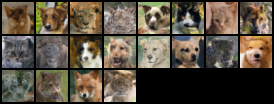

In [25]:
show_images(traj)

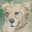

In [36]:
def tensor_to_pil(tensor):
    tensor = (tensor.detach().cpu().numpy() * 0.5 + 0.5).clip(0, 1)  # Renormalize
    return Image.fromarray((tensor * 255).astype(np.uint8).transpose(1, 2, 0))

tensor_to_pil(traj[12])

In [84]:
def create_binary_mask(height, width, i, j, k):
    mask = torch.ones((3, 32, 32))
    mask[:, i:(i+k), j:(j+k)] = 0
    return mask

mask = create_binary_mask(32, 32, 10, 15, 10)

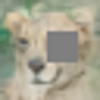

In [85]:
tensor_to_pil(traj[12].cpu() * mask).resize((100,100))

In [101]:
inpainted = pipeline.inpaint(traj[12].unsqueeze(0), mask.unsqueeze(0).to("cuda"))

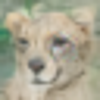

In [102]:
tensor_to_pil(inpainted.detach().cpu().squeeze(0)).resize((100,100))